# **Capstone project: Providing data-driven suggestions for HR**

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

Source data is on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Import packages

In [81]:
# Import packages
### YOUR CODE HERE ### 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pickle

### Load dataset

In [20]:
df0 = pd.read_csv("HR_capstone_dataset.csv")
df0.head(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Initial EDA and data cleaning



In [21]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Rename columns:

In [22]:
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [23]:
df0.rename({'Work_accident':'accident','Department':'department','number_project':'projects','time_spend_company':'tenure','promotion_last_5years':'promotion','average_montly_hours':'hours','satisfaction_level':'satisfaction'},axis='columns',inplace=True)
df0.columns

Index(['satisfaction', 'last_evaluation', 'projects', 'hours', 'tenure',
       'accident', 'left', 'promotion', 'department', 'salary'],
      dtype='object')

In [24]:
df0.describe()

,satisfaction,last_evaluation,projects,hours,tenure,accident,left,promotion
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


No obvious outliers but tenure is worth exploring further.

Check for any missing values in the data:

In [25]:
df0.isna().any().sum()

0

Check for any duplicate entries in the data:

In [26]:
df0.duplicated().sum()

3008

In [27]:
df0[df0.duplicated(keep=False)].sort_values(['satisfaction','last_evaluation'])

,satisfaction,last_evaluation,projects,hours,tenure,accident,left,promotion,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
71,0.09,0.77,5,275,4,0,1,0,product_mng,medium
652,0.09,0.77,6,290,4,0,1,0,technical,medium
...,...,...,...,...,...,...,...,...,...,...
13089,1.00,0.88,6,201,4,0,0,0,technical,low
10691,1.00,0.93,5,231,2,0,0,0,marketing,medium
11375,1.00,0.93,5,167,3,0,0,0,sales,medium
12902,1.00,0.93,5,231,2,0,0,0,marketing,medium


In [28]:
df0.drop_duplicates(inplace=True)

Check for outliers in the data:

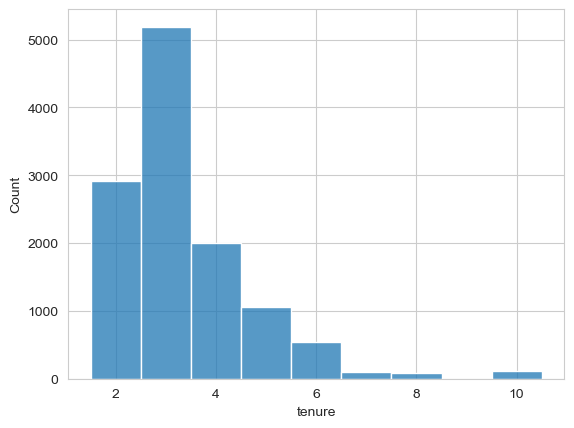

In [62]:
sns.histplot(data=df0, x='tenure',discrete=True);

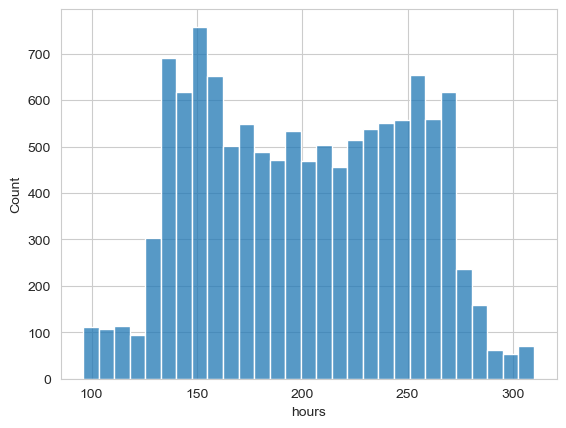

In [30]:
sns.histplot(data=df0, x='hours');

No outliers of concern.


### Exploratory Data Analysis



How many employees left?

In [31]:
print(df0['left'].value_counts())
print(df0['left'].value_counts()/df0.shape[0])

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.833959
1    0.166041
Name: count, dtype: float64


16.6% of the data are from employees who left.

#### Data visualizations

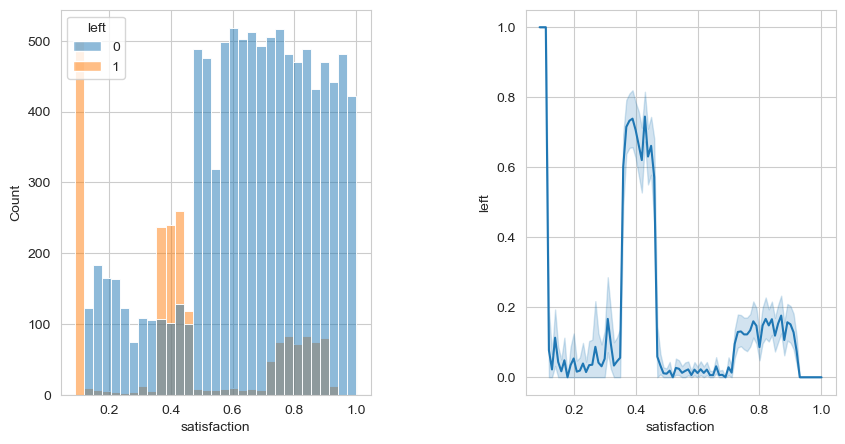

In [45]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5)
sns.histplot(data=df0,x='satisfaction',hue='left',ax=ax1)
sns.lineplot(data=df0,x='satisfaction',y='left',ax=ax2);

Employees who left had lower satisfaction levels. However, the distribution of those who left is multimodal, with peaks at 0.1, 0.4 and 0.8.

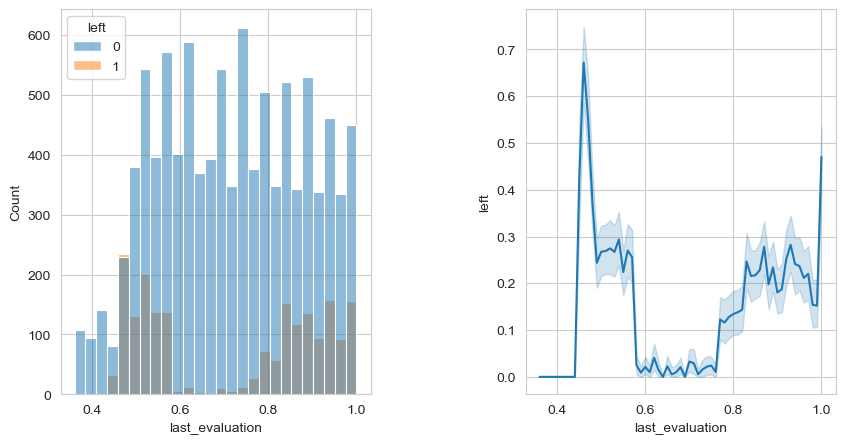

In [44]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5)
sns.histplot(data=df0,x='last_evaluation',hue='left',ax=ax1)
sns.lineplot(data=df0,x='last_evaluation',y='left',ax=ax2);

The last_evaluation score is also multimodal. Note also that it appears not be a continuous or at least smooth variable. 

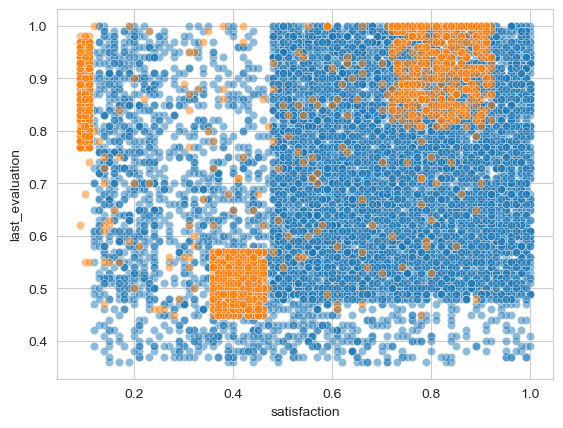

In [49]:
ax=sns.scatterplot(data=df0[df0['left']==0],y='last_evaluation',x='satisfaction',alpha=0.5);
sns.scatterplot(data=df0[df0['left']==1],y='last_evaluation',x='satisfaction',ax=ax,alpha=0.5);#plot seperately to put orange markers above blue

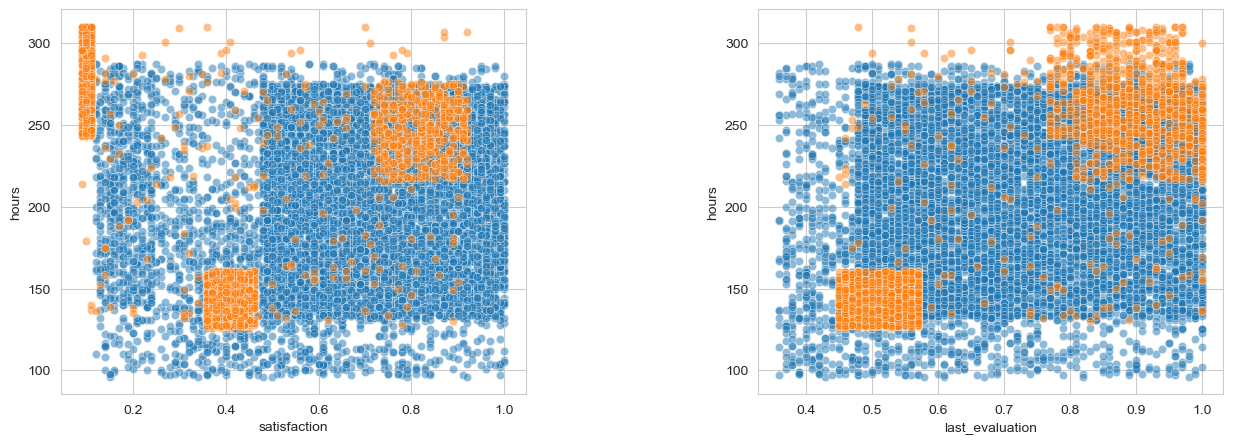

In [52]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
plt.subplots_adjust(wspace=0.5)

sns.scatterplot(data=df0[df0['left']==0],y='hours',x='satisfaction',ax=ax1,alpha=0.5);
sns.scatterplot(data=df0[df0['left']==1],y='hours',x='satisfaction',ax=ax1,alpha=0.5);#plot seperately to put orange markers above blue

sns.scatterplot(data=df0[df0['left']==0],y='hours',x='last_evaluation',ax=ax2,alpha=0.5);
sns.scatterplot(data=df0[df0['left']==1],y='hours',x='last_evaluation',ax=ax2,alpha=0.5);#plot seperately to put orange markers above blue

The dataset is obviously synthetic!
It seems that together satisfaction, hours and last_evaluation should have predictive power.

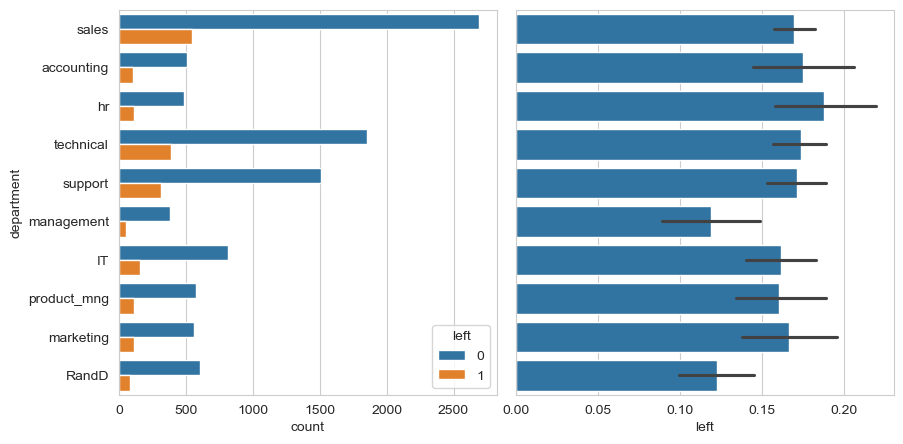

In [53]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.05)
sns.countplot(data=df0,y='department',hue='left',ax=ax1)
sns.barplot(data=df0,y='department',x='left',ax=ax2)
ax2.set(ylabel='',yticks=[]);

Management and RandD appear to have lower leaving rates (~12% vs ~17%).

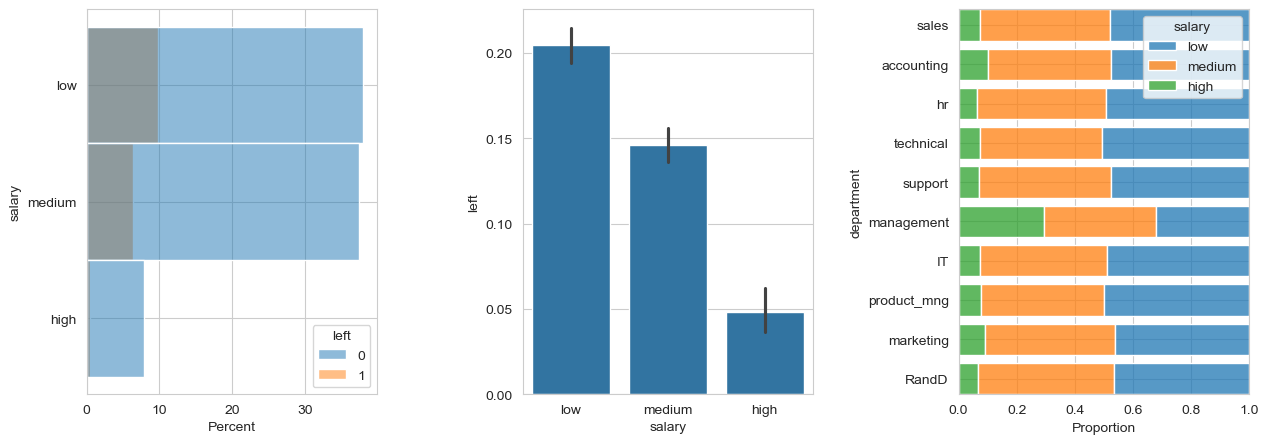

In [61]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(15,5))
plt.subplots_adjust(wspace=0.5)
sns.histplot(data=df0,y='salary',hue='left',stat='percent',ax=ax1)
sns.barplot(data=df0,y='left',x='salary',ax=ax2);
sns.histplot(data=df0,y='department',hue='salary',multiple='fill',stat='proportion',shrink=0.8,ax=ax3);
#ax2.set(ylabel='',yticks=[]);

Employees with higher salaries are less likely to leave than employees with low salaries (5% vs 20%). This may be the reason for lower leaving rates for management. However, R&D also have low leaving rates but do not have a higher proportion of high salary earners.

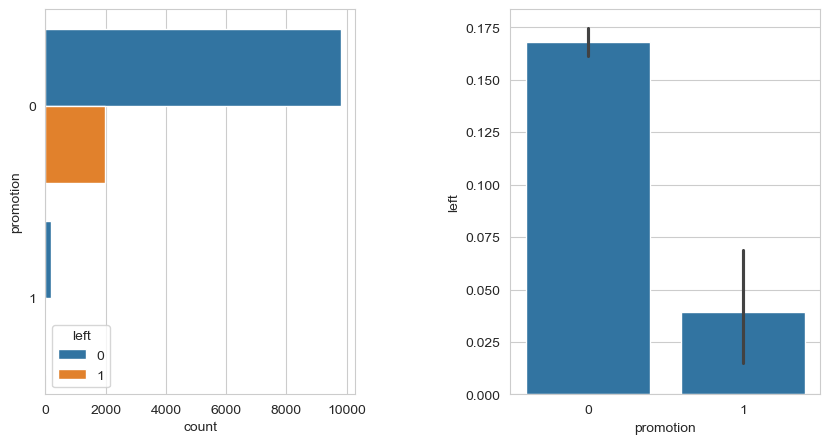

In [65]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=df0,y='promotion',hue='left',ax=ax1);
sns.barplot(data=df0,x='promotion',y='left',ax=ax2);
#ax2.set(ylabel='',yticks=[]);

Promoted employees are less likely to leave (~8% vs ~17%)

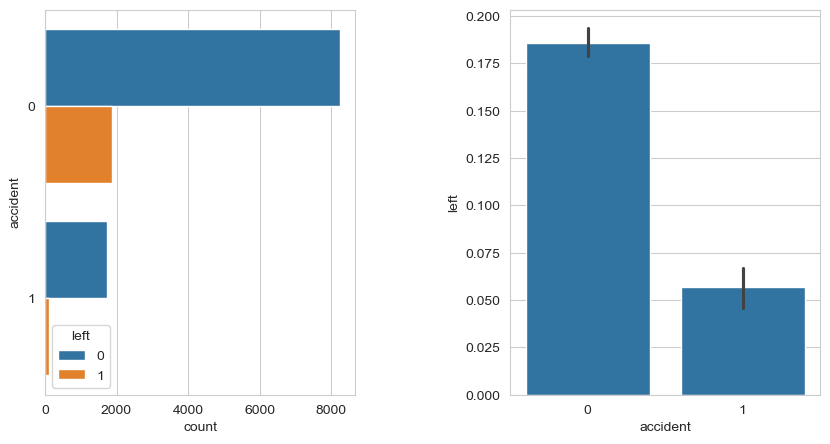

In [69]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=df0,y='accident',hue='left',ax=ax1);
sns.barplot(data=df0,x='accident',y='left',ax=ax2);
#ax2.set(ylabel='',yticks=[]);

Employees who had an accident are less likely to leave.

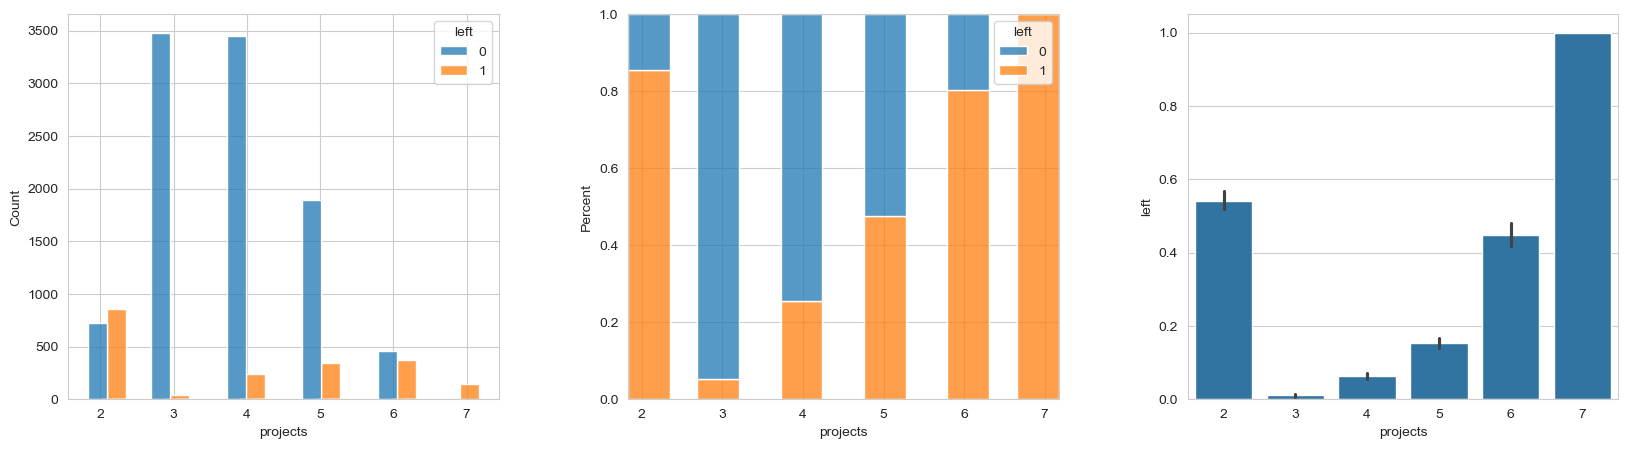

In [72]:
fig, (ax1, ax2, ax3)=plt.subplots(1,3,figsize=(20,5))
plt.subplots_adjust(wspace=0.3)
sns.histplot(data=df0,x='projects',hue='left',multiple='dodge',shrink=3,stat='count',common_norm=False,ax=ax1)
sns.histplot(data=df0,x='projects',hue='left',multiple='fill',shrink=3,stat='percent',common_norm=False,ax=ax2);
sns.barplot(data=df0,x='projects',y='left',ax=ax3);

There is a clear but non-linear dependence on the number of projects

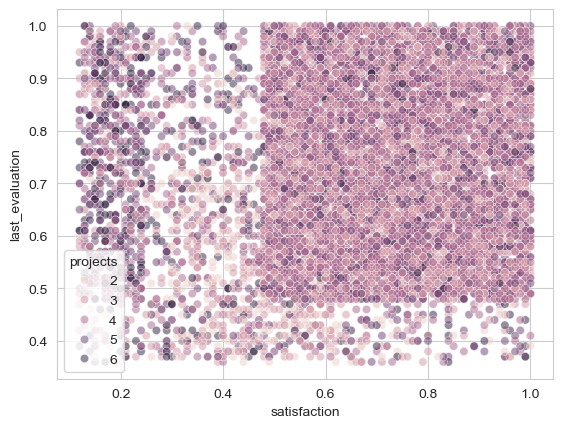

In [76]:
ax=sns.scatterplot(data=df0[df0['left']==0],y='last_evaluation',x='satisfaction',hue='projects',alpha=0.5);

Number of projects is independent of last_evaluation and satisfaction

<Axes: xlabel='projects', ylabel='hours'>

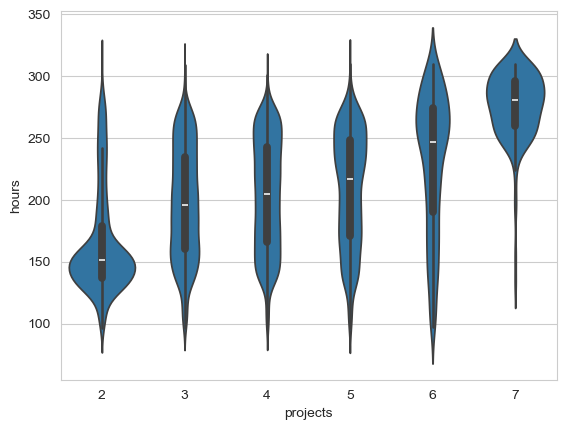

In [79]:
sns.violinplot(data=df0,x='projects',y='hours')

More projects are associated with longer hours

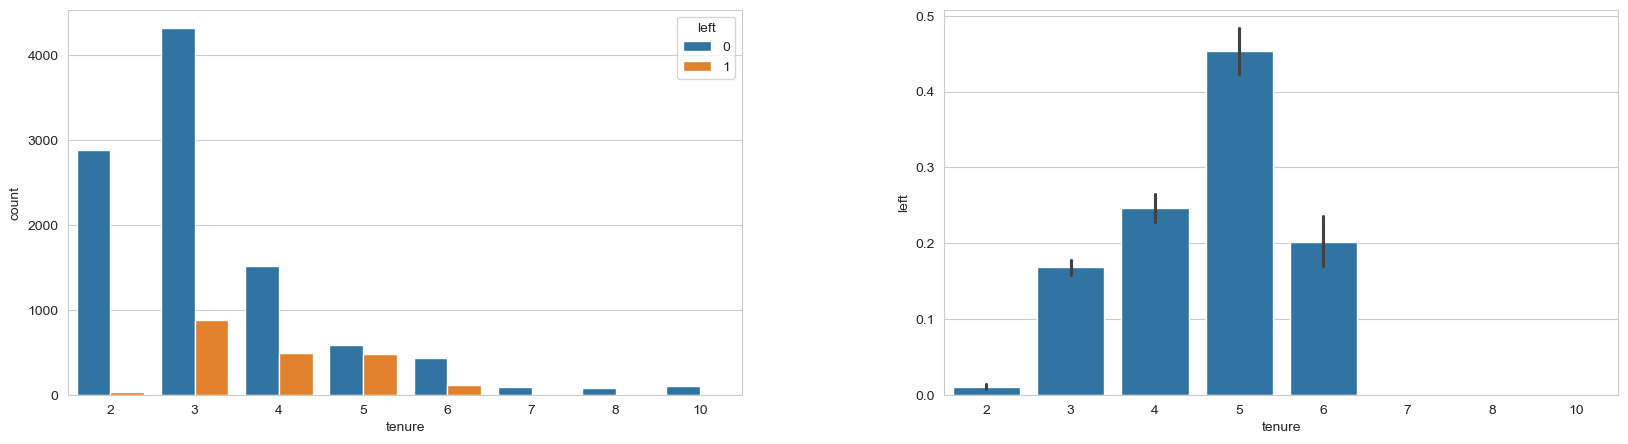

In [80]:
fig, (ax1, ax2)=plt.subplots(1,2,figsize=(20,5))
plt.subplots_adjust(wspace=0.3)
sns.countplot(data=df0,x='tenure',hue='left',ax=ax1)
sns.barplot(data=df0,x='tenure',y='left',ax=ax2);

Employees with 5 years tenure were most likely to have left.

### Insights

Staff with 2, 6 or 7 projects have a much higher chance of leaving than staff with 3, 4 or 5 projects
Staff who had an accident or a promotion are less likely to leave
Staff who work between ~160 and ~215 hours have a very low likelihood to leave. The highest hours are associated with having many projects.
Staff with lower salaries have higher chances to leave.
Staff with satisfaction scores around 0.4 have a much higher chance of leaving
Staff with a last evaluation score of less than 0.6 or higher than 0.8 have an increased risk of leaving
Staff tend to leave after 3-6 years.
Overall satisfaction, last_evaluation, hours and projects are likely to be the best predictors. The non-linear relationships indicate that a decision tree is more suitable than logistic regression.

### Model

Randon forest may work well due to the non-linear relationship with the independent variables

### Modeling

Since only 2 departments should lower leaving levels, we replace department with two boolean variables
Dummy variables:

In [122]:
df1=df0
df1['RandD']=df1['department']=='RandD'
df1['management']=df1['department']=='RandD'
df1=df1.drop(columns=['department'])
df1=pd.get_dummies(df1,drop_first=True)# turn 'department' and 'salary' into dummy variables
df1.head()

,satisfaction,last_evaluation,projects,hours,tenure,accident,left,promotion,RandD,management,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,False,False,True,False
1,0.80,0.86,5,262,6,0,1,0,False,False,False,True
2,0.11,0.88,7,272,4,0,1,0,False,False,False,True
3,0.72,0.87,5,223,5,0,1,0,False,False,True,False
4,0.37,0.52,2,159,3,0,1,0,False,False,True,False


Class balance:

In [107]:
df1.value_counts('left')/df1.shape[0]

left
0    0.833959
1    0.166041
Name: count, dtype: float64

Only 17% of data are for employees who left. Therefore, predicting no risk of leaving for every staff member, would still result in an accuracy of 83%. False negatives mean not identifying an employee who will leave. False positives means falsely identifying an employee as a leaver with the resultant cost of the intervention. As the goal of the project is to improve employee satisfaction, the latter case still falls within the project goals. The focus should be on reducing the number of false negatives i.e. on a high recall/sensitivity.

#### Recall evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example.
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.

Variables:

In [157]:
y=df1['left']
X=df1.drop(columns='left')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify=y, random_state = 0)

In [163]:
rf = RandomForestClassifier(random_state=0)
cv_params = {'max_depth': [4,5,6], 
             'min_samples_leaf': [1,2,5],
             'min_samples_split': [2,3],
             'max_features': [1.0],
             'n_estimators': [200],
             #'max_samples' : [0.99]
             }
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall',n_jobs=-1)

In [164]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: total: 1.52 s
Wall time: 13.7 s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6], 'max_features': [1.0],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 3], 'n_estimators': [200]},
             refit='recall',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [165]:
with open('Capstone_randomforest' + '.pickle', 'wb') as to_write:
        pickle.dump(rf_cv, to_write)

In [166]:
rf_cv.best_score_

0.9215343635470585

In [167]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Helper function:

In [141]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [168]:
results = make_results('Random forest',rf_cv,'recall')
results

,model,precision,recall,F1,accuracy,auc
0,Random forest,0.946609,0.921534,0.933823,0.978315,0.978434


Evaluate on test data:

Helper function

In [152]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = metrics.roc_auc_score(y_test_data, preds)
    accuracy = metrics.accuracy_score(y_test_data, preds)
    precision = metrics.precision_score(y_test_data, preds)
    recall = metrics.recall_score(y_test_data, preds)
    f1 = metrics.f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                         })
  
    return table

In [169]:
results_test=get_scores('Random forest test',rf_cv,X_test,y_test)
results=pd.concat([results,results_test],axis=0)
results

,model,precision,recall,F1,accuracy,auc
0,Random forest,0.946609,0.921534,0.933823,0.978315,0.978434
0,Random forest test,0.958225,0.922111,0.939821,0.980409,0.957057


In [172]:
rf_preds=rf_cv.best_estimator_.predict(X_test)
r=metrics.classification_report(y_test,rf_preds,target_names=['Predicted would not leave', 'Predicted would leave'])
print(r)

                           precision    recall  f1-score   support

Predicted would not leave       0.98      0.99      0.99      2001
    Predicted would leave       0.96      0.92      0.94       398

                 accuracy                           0.98      2399
                macro avg       0.97      0.96      0.96      2399
             weighted avg       0.98      0.98      0.98      2399



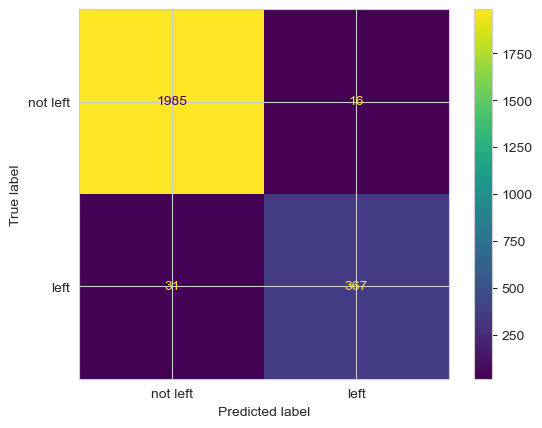

In [171]:
cm=metrics.confusion_matrix(y_test,rf_preds)
p=metrics.ConfusionMatrixDisplay(cm,display_labels=['not left','left'])#display_labels=xgb_cv.classes_
p.plot(values_format='d');

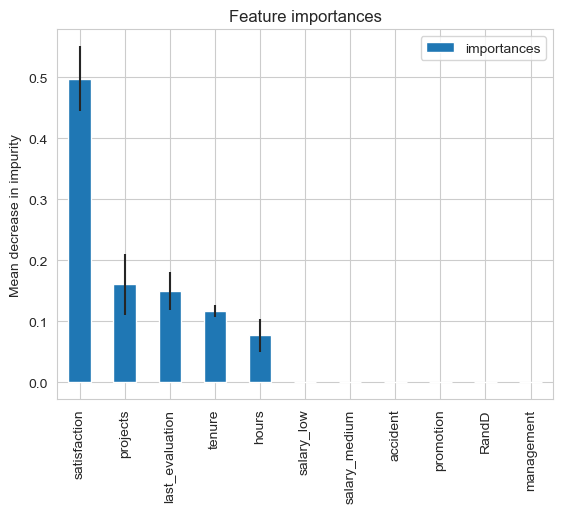

In [178]:
importances = rf_cv.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_cv.best_estimator_.estimators_], axis=0)
rf_importances = pd.DataFrame(data={'importances':importances,'std':std}, index=X_test.columns)

rf_importances = rf_importances.sort_values(ascending=False,by='importances')[:15]

#fig, ax = plt.subplots(figsize=(8,5))
ax=rf_importances.plot.bar(yerr='std')
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')

### Conclusion


On the test data, the model correctly identified 92% of employees who actually left as at risk of leaving. At the same time 95.8% of employees identified as at risk of leaving actually left. Overall 98% of the data was correctly identified.

While the most important feature of the model is satisfaction, the numbers of projects came second and suggests a causative reason for employees leaving rather a measure of their dissatisfaction. The number of hours was also very relevant.

### Recommendations, Next Steps

Employees should have 3, 4 or occasionaly 5 projects. Having too few (2) or too many projects (6 or 7) is associated with dissatisfaction and low retenation. Related to that are the number of hours worked.